In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, ifftshift, ifft2
from fastmri.data.subsample import create_mask_for_mask_type


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"  

In [13]:
def load_mri_data(filepath):
    with h5py.File(filepath, 'r') as f:
        kspace = f['kspace'][()]
    return kspace


def plot_kspace_and_image(kspace_slice):
    kspace_slice = np.squeeze(kspace_slice)
    image_space = fftshift(ifft2(ifftshift(kspace_slice)))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(np.log(np.abs(kspace_slice) + 1e-9), cmap='gray')
    axes[0].set_title('k-space')
    axes[1].imshow(np.abs(image_space), cmap='gray')
    axes[1].set_title('Image space')
    plt.show()

    return image_space


def plot_magnitude_of_all_slices(kspace):
    num_slices = kspace.shape[0]
    grid_size = int(np.ceil(np.sqrt(num_slices)))  # Calculate grid size
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    for i in range(grid_size * grid_size):  # Iterate over the total number of grid cells
        row = i // grid_size
        col = i % grid_size
        ax = axes[row, col]
        if i < num_slices:
            kspace_slice = np.squeeze(kspace[i])
            image_space = fftshift(ifft2(ifftshift(kspace_slice))) # Inverse Fourier Transform to get image space, each point is a calculus 
            ax.imshow(np.abs(image_space), cmap='gray')
            ax.set_title(f'Slice {i}')
        ax.axis('off')  # Turn off the axis whether or not there is an image
    plt.savefig('all_slices.png')
    plt.show()



In [14]:
def plot_components(center_slice):
    
    center_slice = np.squeeze(center_slice)
    image_space = fftshift(ifft2(ifftshift(center_slice)))
    magnitude = np.abs(image_space)
    phase = np.angle(image_space)
    real_part = np.real(image_space)
    imaginary_part = np.imag(image_space)
    
    titles = ['Magnitude', 'Phase', 'Real Part', 'Imaginary Part']
    components = [magnitude, phase, real_part, imaginary_part]
    labels = ['Signal Intensity', 'Phase (radians)', 'Real Signal', 'Imaginary Signal']

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    for ax, component, title, label in zip(axes.flatten(), components, titles, labels):
        im = ax.imshow(component, cmap='gray')
        ax.set_title(title)
        fig.colorbar(im, ax=ax, label=label)
    plt.tight_layout()
    plt.savefig('components.png')
    plt.show()

    print('Phase range:', phase.min(), 'to', phase.max())


In [5]:
#filepath = 'file061.h5' 
filepath = 'fastMRIdataOnecoil\\multicoil_train\\file063.h5'
kspace = load_mri_data(filepath)


In [6]:
kspace.shape
kspace[2].shape  # Shape of the third slice
kspace[2][0]     # the magnitude graph of the coil of the third slice
kspace[2][0].shape
kspace[2][0][0,1]  # the magnitude of the coil of the third slice at the 0,1 position



(45, 1, 184, 160)

(1, 184, 160)

array([[ 1.5099766e-04-8.4318061e-05j, -4.1759486e-04-1.1082652e-03j,
         4.7993957e-04+3.5491440e-04j, ...,
         1.2362184e-03-1.8722855e-03j,  2.8002411e-04+1.1360617e-04j,
         8.6125929e-04+7.9202221e-04j],
       [-9.3381491e-04+3.3303795e-03j,  1.6047630e-03+1.0183740e-03j,
         2.2982375e-03+1.3675571e-03j, ...,
        -6.3220371e-04+6.2716004e-05j, -3.0592195e-04-1.8727215e-04j,
        -9.7753527e-04-9.5146958e-04j],
       [-1.0213775e-03+1.6103170e-03j,  9.0979440e-05-1.6096511e-03j,
         1.2671596e-03-2.4299070e-03j, ...,
         1.4713380e-03+8.9989888e-04j,  4.2401452e-04+6.1418256e-04j,
        -7.1929455e-05-3.7187914e-04j],
       ...,
       [-1.3222330e-03-3.5597055e-04j, -7.8216381e-04-1.1492907e-03j,
         9.8713452e-04-1.3979392e-03j, ...,
         1.4101489e-03+6.1308092e-04j,  1.1829542e-03+2.3759477e-04j,
         1.6644478e-03+4.6709424e-04j],
       [-2.7074446e-03+1.8649460e-03j, -8.7390200e-04-8.3007710e-04j,
         7.6060573e-04

(184, 160)

(-0.00041759486-0.0011082652j)

In [7]:
# Select the center slice
center_slice_index = kspace.shape[0] // 2   # 
center_slice = kspace[center_slice_index]

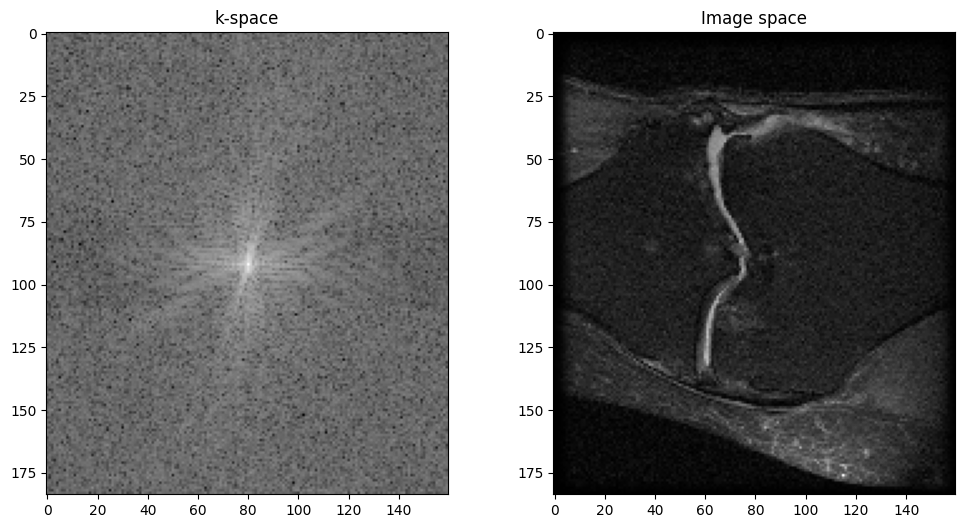

(184, 160)

In [8]:
# Plot k-space and image space for the center slice
transform=plot_kspace_and_image(center_slice)
transform.shape 

In [11]:
center_slice[0][0,1] 
transform[0,1] 

(0.00050247385+0.00027197224j)

(-1.3735388306669886e-08-3.781989854549897e-08j)

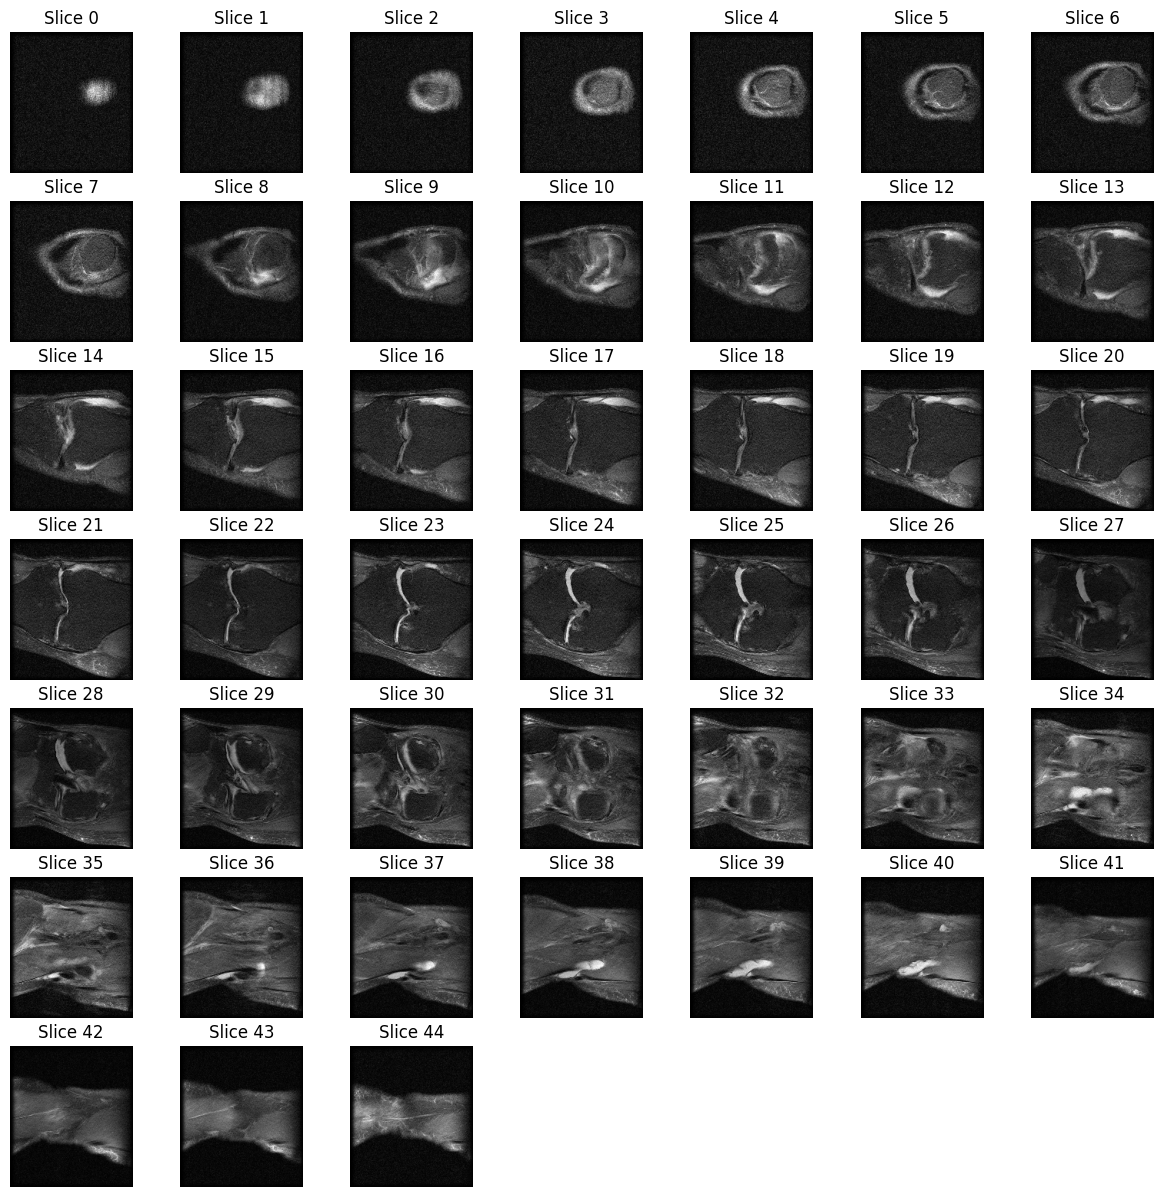

In [15]:
# Plot the magnitude image of all slices
plot_magnitude_of_all_slices(kspace) 


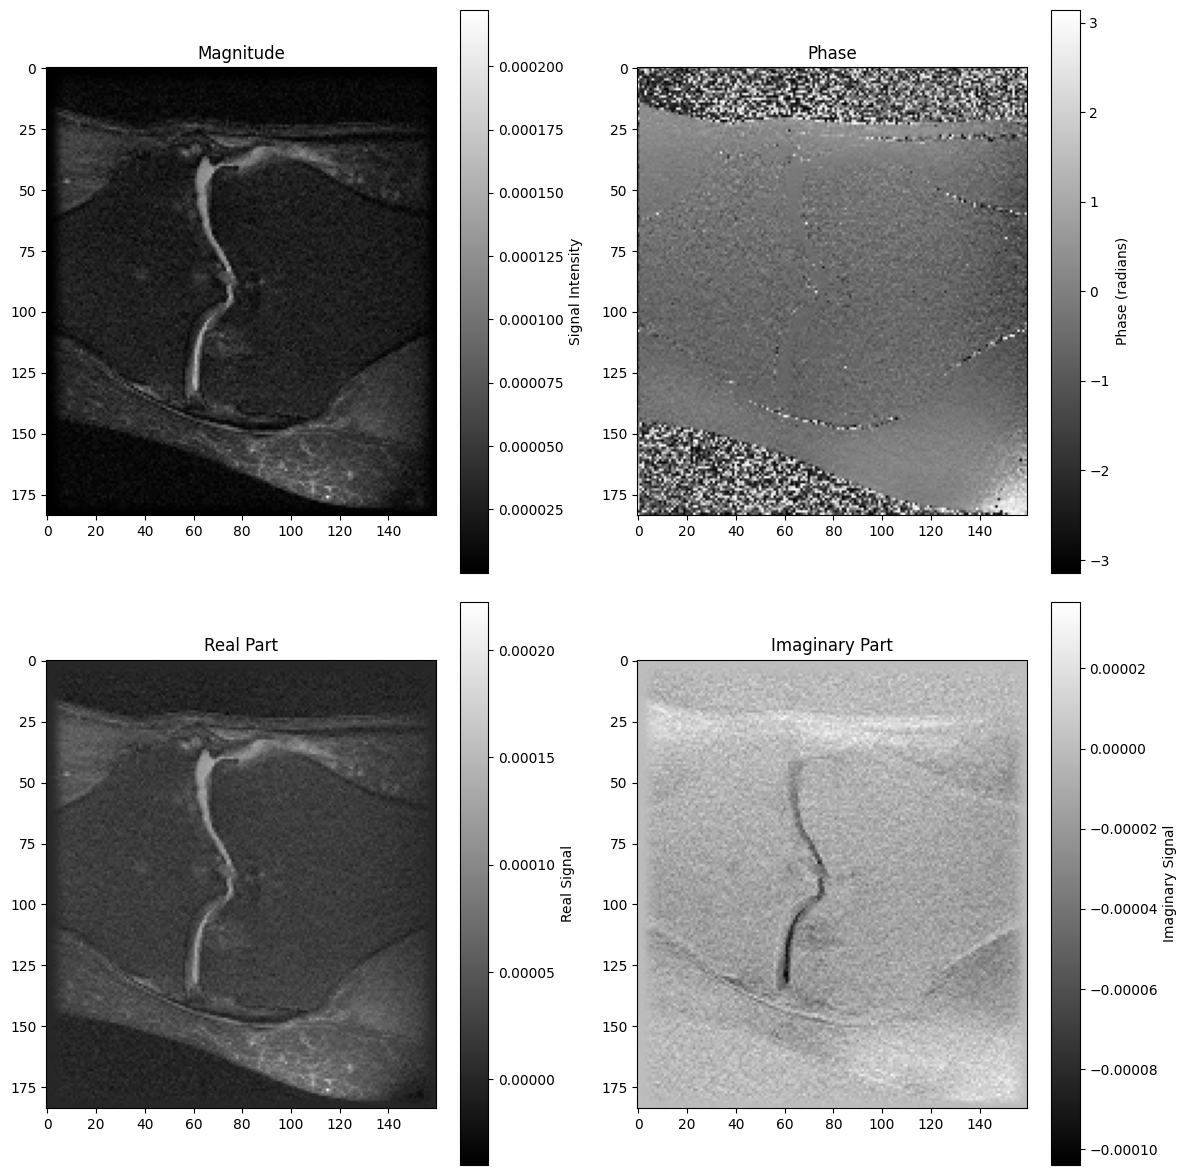

Phase range: -3.1388670764029345 to 3.141521039183217


In [16]:
# Plot the magnitude, phase, real and imaginary components for the center slice
plot_components(center_slice)

## apply different mask types 

In [74]:
def create_mask(mask_type, center_fractions, accelerations):
    mask_func = create_mask_for_mask_type(mask_type, center_fractions, accelerations)
    return mask_func

def apply_mask(kspace_slice, mask_func):
    shape = kspace_slice.shape
    mask, _ = mask_func(shape, seed=0)
    mask = mask.numpy()  # Ensure mask is in numpy format
    
    print(f"kspace_slice shape: {kspace_slice.shape}")
    print(f"mask shape: {mask.shape}")

    masked_kspace = kspace_slice * mask
    return masked_kspace, mask

def plot_images(original, masked, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(np.abs(original.squeeze()), cmap='gray')  # Use squeeze to remove single-dimensional entries
    axes[0].set_title('Original ' + title)
    axes[1].imshow(np.abs(masked.squeeze()), cmap='gray')  # Use squeeze to remove single-dimensional entries
    axes[1].set_title('Masked ' + title)
    plt.show()

In [94]:
def apply_mask(kspace_slice, mask_func):
    
    shape = kspace_slice.shape
    # 
    mask, _ = mask_func(shape, seed=0)  # Create the mask
    mask = mask.numpy()  # Ensure mask is in numpy format
    

    if mask.shape != shape:
    
        try:
            mask = np.broadcast_to(mask, shape)
        except ValueError as e:
            raise ValueError(f"Mask shape {mask.shape} cannot be broadcast to k-space shape {shape}. Error: {str(e)}")

    print(f"kspace_slice shape: {kspace_slice.shape}")
    print(f"mask shape: {mask.shape}")

    masked_kspace = kspace_slice * mask   # Apply the mask to k-space
    return masked_kspace, mask


def plot_images(original, masked, title):
    
    def compute_vmin_vmax(image, percentile=99):   # Compute vmin and vmax for the image
        vmax = np.percentile(image, percentile)
        vmin = np.percentile(image, 100 - percentile)
        return vmin, vmax

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    
    original_squeezed = np.abs(original.squeeze())  # Use squeeze to remove single-dimensional entries
    vmin, vmax = compute_vmin_vmax(original_squeezed)  
    axes[0].imshow(original_squeezed, cmap='gray', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'initial {title}')

    
    masked_squeezed = np.abs(masked.squeeze())
    vmin, vmax = compute_vmin_vmax(masked_squeezed)
    axes[1].imshow(masked_squeezed, cmap='gray', vmin=vmin, vmax=vmax)
    axes[1].set_title(f'masked {title}')

    
    plt.tight_layout()
    plt.show()



In [95]:
filepath = 'fastMRIdataOnecoil\\multicoil_test\\file124.h5'
kspace = load_mri_data(filepath)

# Select the center slice for visualization
center_slice_index = kspace.shape[0] // 2
center_slice = kspace[center_slice_index]

# Fully sampled image
fully_sampled_image = fftshift(ifft2(ifftshift(center_slice)))


###  random mask 

In [96]:
# Create a subsampling mask
mask_type = 'random'  
center_fractions = [0.2]
accelerations = [2]

mask_func = create_mask(mask_type, center_fractions, accelerations)

# Apply mask to k-space data
masked_kspace, mask = apply_mask(center_slice, mask_func)
masked_image = fftshift(ifft2(ifftshift(masked_kspace))) 



kspace_slice shape: (1, 184, 160)
mask shape: (1, 184, 160)


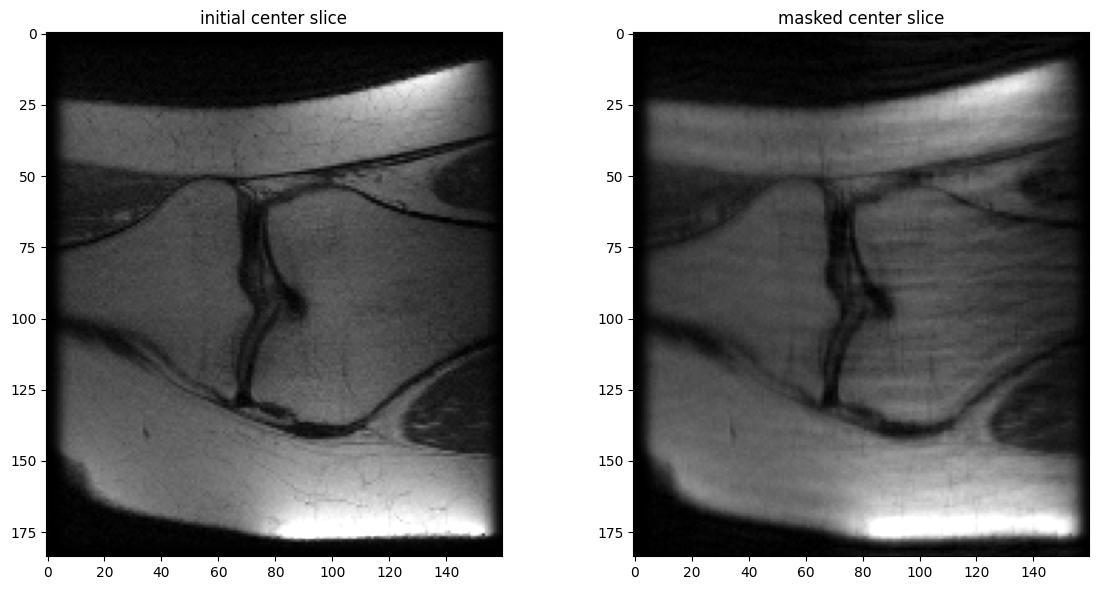

In [97]:
# Plot images for comparison
plot_images(fully_sampled_image, masked_image, 'center slice')

Text(0.5, 1.0, 'full k-space')

Text(0.5, 1.0, 'random masked k-space')

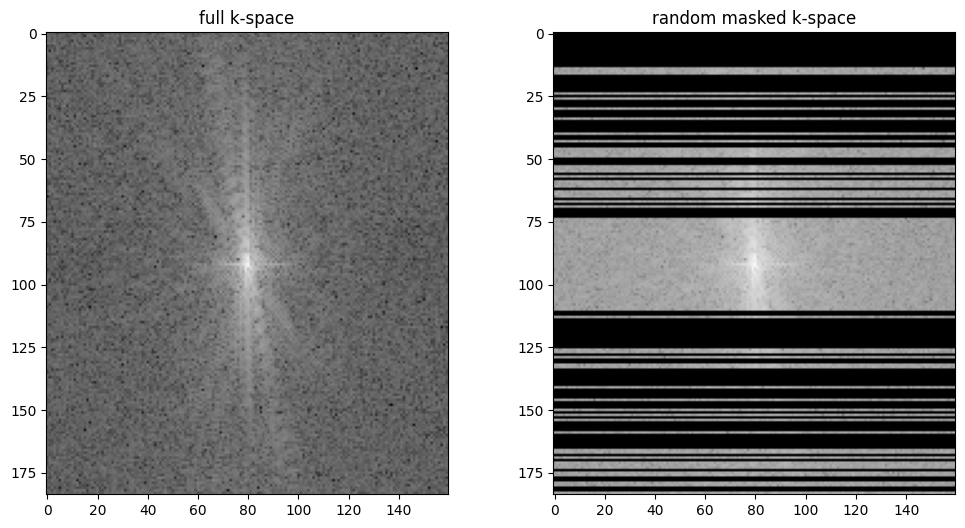

In [98]:
center_slice_squeezed = np.squeeze(center_slice)
masked_kspace_squeezed = np.squeeze(masked_kspace)

# Plot the fully sampled k-space and the masked k-space 
def safe_log(x, min_val=1e-9):
    return np.log(np.abs(x) + min_val)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(safe_log(center_slice_squeezed), cmap='gray')
axes[0].set_title('full k-space') 
axes[1].imshow(safe_log(masked_kspace_squeezed), cmap='gray')
axes[1].set_title(f'{mask_type} masked k-space')
plt.show()

### magic mask 

kspace_slice shape: (1, 184, 160)
mask shape: (1, 184, 160)


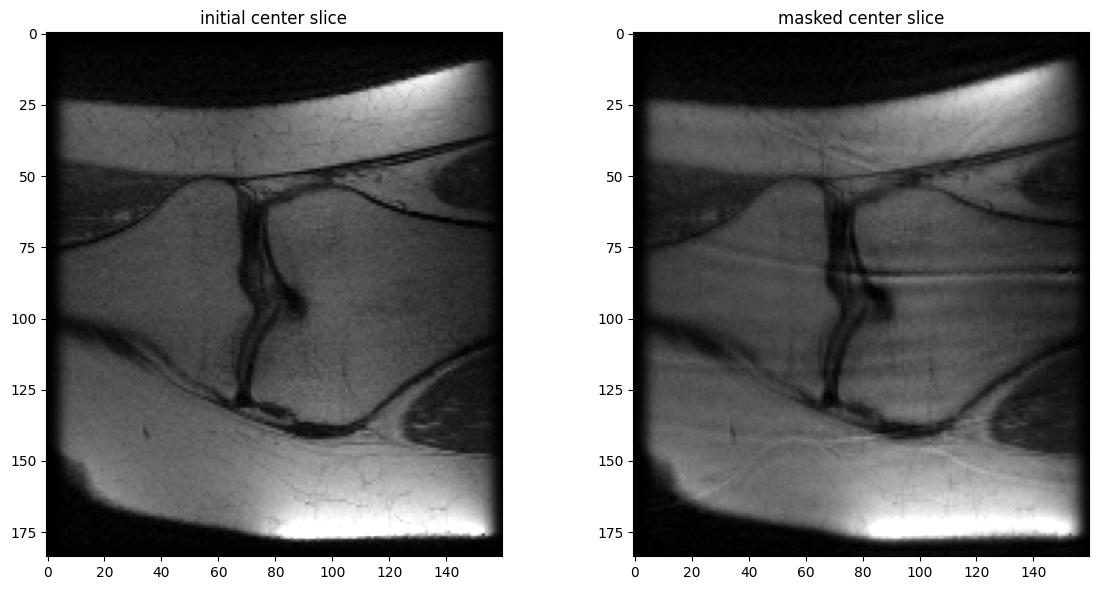

In [99]:
mask_type = 'magic'  
center_fractions = [0.25]
accelerations = [2]

mask_func = create_mask(mask_type, center_fractions, accelerations)

# Apply mask to k-space data
masked_kspace, mask = apply_mask(center_slice, mask_func)
masked_image = fftshift(ifft2(ifftshift(masked_kspace))) 

plot_images(fully_sampled_image, masked_image, 'center slice')

Text(0.5, 1.0, 'full k-space')

Text(0.5, 1.0, 'magic masked k-space')

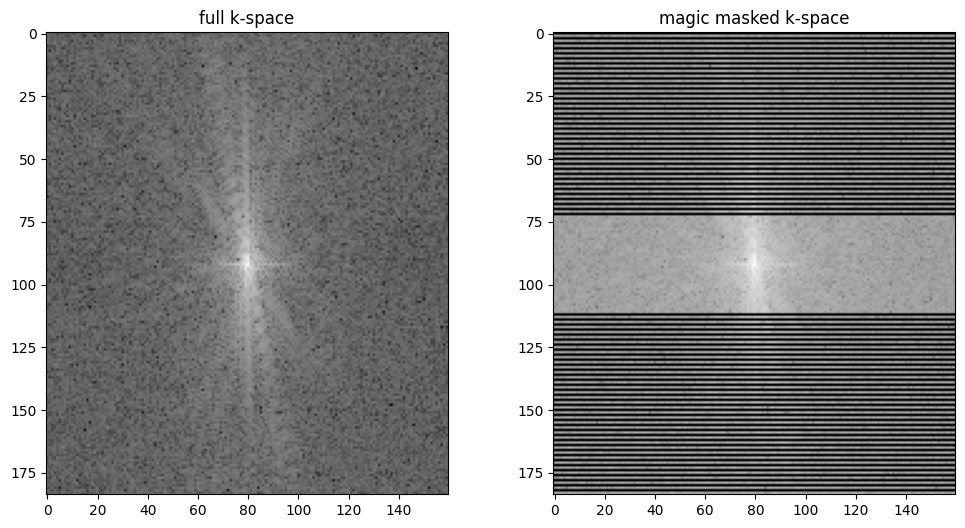

In [100]:
center_slice_squeezed = np.squeeze(center_slice)
masked_kspace_squeezed = np.squeeze(masked_kspace)

# Plot the fully sampled k-space and the masked k-space
def safe_log(x, min_val=1e-9):
    return np.log(np.abs(x) + min_val)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(safe_log(center_slice_squeezed), cmap='gray')
axes[0].set_title('full k-space')
axes[1].imshow(safe_log(masked_kspace_squeezed), cmap='gray')
axes[1].set_title(f'{mask_type} masked k-space')
plt.show()

### epucid mask  

kspace_slice shape: (1, 184, 160)
mask shape: (1, 184, 160)


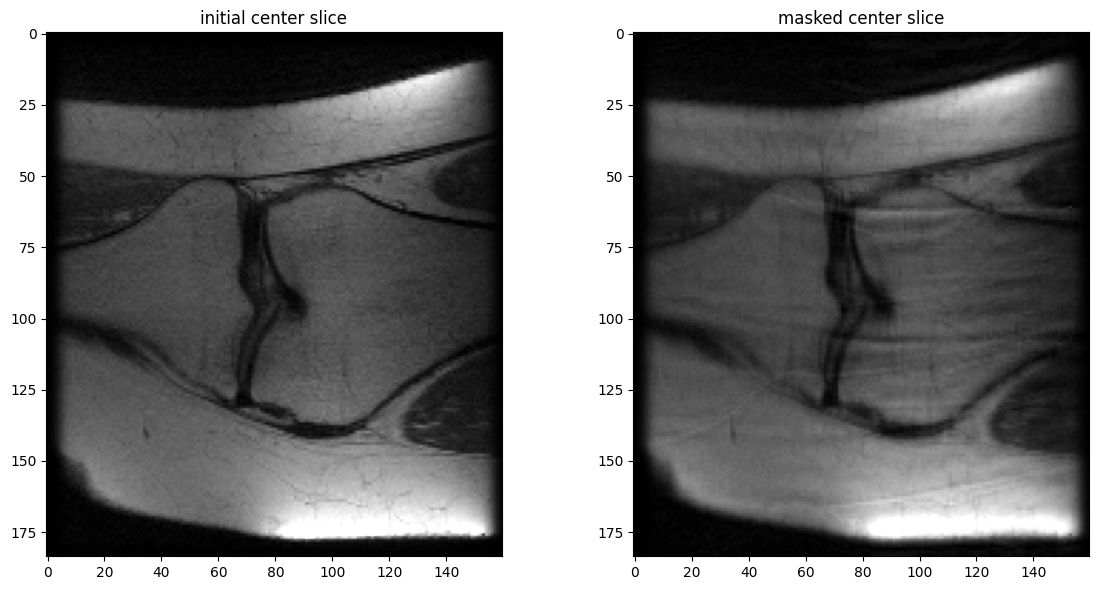

In [101]:

mask_type = "equispaced_fraction"
center_fractions = [0.25]
accelerations = [2]

mask_func = create_mask(mask_type, center_fractions, accelerations)

# Apply mask to k-space data
masked_kspace, mask = apply_mask(center_slice, mask_func)
masked_image = fftshift(ifft2(ifftshift(masked_kspace))) 

plot_images(fully_sampled_image, masked_image, 'center slice')



Text(0.5, 1.0, 'full k-space')

Text(0.5, 1.0, 'equispaced_fraction masked k-space')

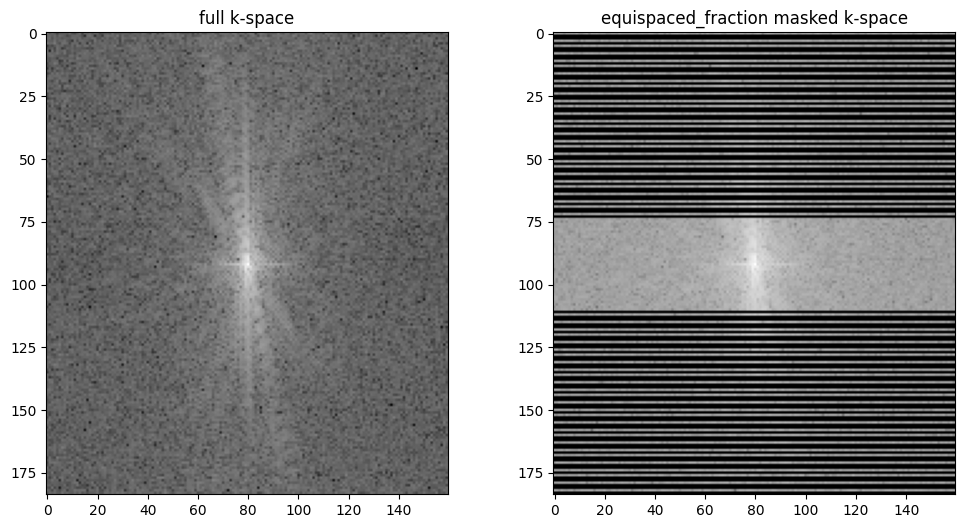

In [102]:
center_slice_squeezed = np.squeeze(center_slice)
masked_kspace_squeezed = np.squeeze(masked_kspace)

# Plot the fully sampled k-space and the masked k-space
def safe_log(x, min_val=1e-9):
    return np.log(np.abs(x) + min_val)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(safe_log(center_slice_squeezed), cmap='gray')
axes[0].set_title('full k-space')
axes[1].imshow(safe_log(masked_kspace_squeezed), cmap='gray')
axes[1].set_title(f'{mask_type} masked k-space')
plt.show()